<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning-UAS/blob/main/Chapter_5_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Persiapan

In [1]:
# Cek versi Python dan Scikit-Learn
import sys, sklearn
assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"

# Impor umum
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

# Stabilkan output random
np.random.seed(42)

# Konfigurasi plot
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Direktori penyimpanan gambar
IMAGES_PATH = os.path.join(".", "images", "svm")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Fungsi menyimpan gambar
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("Saving figure:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Klasifikasi Linear SVM

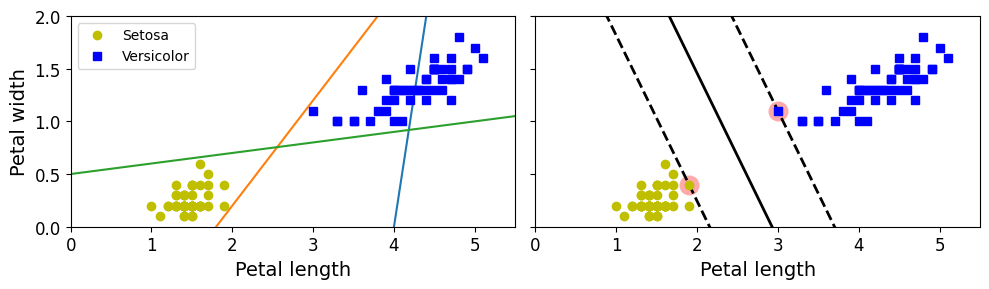

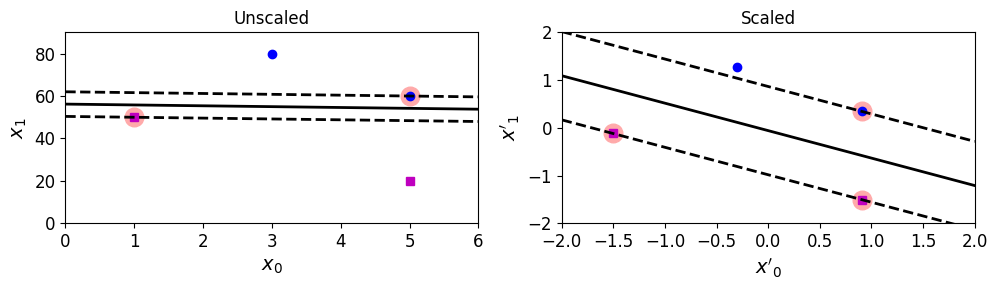

In [2]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Ambil data Iris: gunakan 2 kelas (setosa & versicolor), dan 2 fitur
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, width
y = (iris["target"] == 0) | (iris["target"] == 1)
X, y = X[y], iris["target"][y]

# Latih SVM linear tanpa batasan margin (C = inf)
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

# Fungsi bantu visualisasi SVM
def plot_svc_decision_boundary(clf, xmin, xmax):
    w = clf.coef_[0]
    b = clf.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1 / w[1]
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, decision_boundary + margin, "k--", linewidth=2)
    plt.plot(x0, decision_boundary - margin, "k--", linewidth=2)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=180, facecolors='#FFAAAA')

# Plot: Perbandingan model buruk vs SVM optimal
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
x0 = np.linspace(0, 5.5, 200)
bad_preds = [5*x0 - 20, x0 - 1.8, 0.1 * x0 + 0.5]

plt.sca(axes[0])
for pred in bad_preds:
    plt.plot(x0, pred)
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Versicolor")
plt.legend(); plt.xlabel("Petal length"); plt.ylabel("Petal width"); plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[y==0, 0], X[y==0, 1], "yo")
plt.plot(X[y==1, 0], X[y==1, 1], "bs")
plt.xlabel("Petal length"); plt.axis([0, 5.5, 0, 2])
plt.tight_layout()
plt.show()

# Skala fitur memengaruhi SVM
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]], dtype=np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(Xs[ys==0, 0], Xs[ys==0, 1], "ms")
plt.plot(Xs[ys==1, 0], Xs[ys==1, 1], "bo")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.title("Unscaled"); plt.xlabel("$x_0$"); plt.ylabel("$x_1$"); plt.axis([0, 6, 0, 90])

# Skala fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[ys==0, 0], X_scaled[ys==0, 1], "ms")
plt.plot(X_scaled[ys==1, 0], X_scaled[ys==1, 1], "bo")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.title("Scaled"); plt.xlabel("$x'_0$"); plt.ylabel("$x'_1$"); plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

## Soft Margin Classifictaion

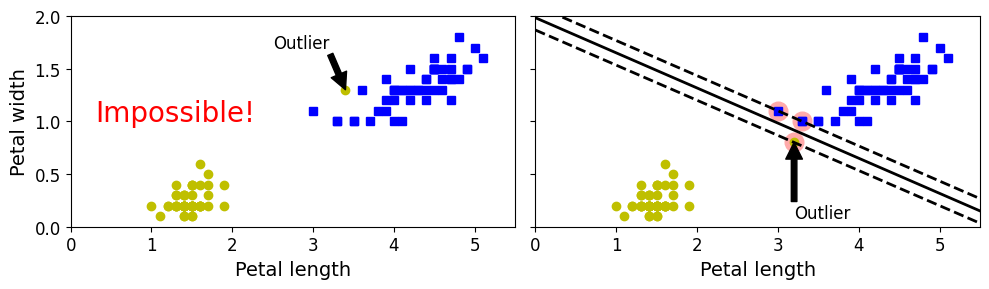

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


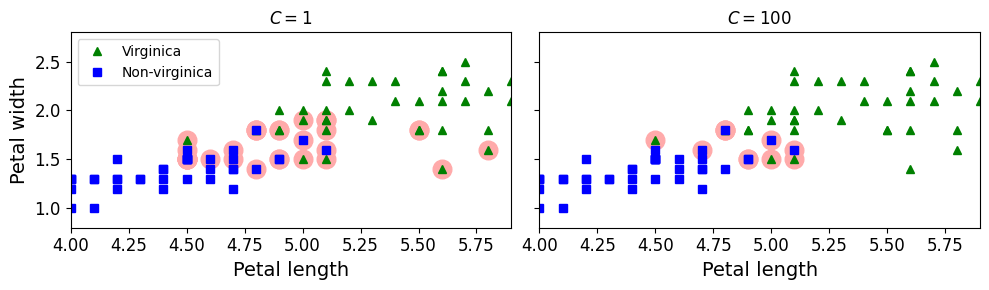

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# === Dataset & Fitur ===
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length & width
y_bin = (iris["target"] == 2).astype(np.float64)  # Virginica vs lainnya
X_small = X[(iris["target"] == 0) | (iris["target"] == 1)]
y_small = iris["target"][(iris["target"] == 0) | (iris["target"] == 1)]

# === Outlier Sensitivity Plot ===
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.vstack([X_small, X_outliers[:1]])
yo1 = np.concatenate([y_small, y_outliers[:1]])
Xo2 = np.vstack([X_small, X_outliers[1:]])
yo2 = np.concatenate([y_small, y_outliers[1:]])

clf_o2 = SVC(kernel="linear", C=1e9)
clf_o2.fit(Xo2, yo2)

def plot_boundary(clf, xmin, xmax):
    w = clf.coef_[0]; b = clf.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    decision = -w[0]/w[1]*x0 - b/w[1]
    margin = 1/w[1]
    plt.plot(x0, decision, "k-", linewidth=2)
    plt.plot(x0, decision + margin, "k--", linewidth=2)
    plt.plot(x0, decision - margin, "k--", linewidth=2)
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=180, facecolors='#FFAAAA')

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
# Outlier pertama (tanpa training)
plt.sca(axes[0])
plt.plot(Xo1[yo1==1][:, 0], Xo1[yo1==1][:, 1], "bs")
plt.plot(Xo1[yo1==0][:, 0], Xo1[yo1==0][:, 1], "yo")
plt.annotate("Outlier", xy=X_outliers[0], xytext=(2.5, 1.7),
             arrowprops=dict(facecolor='black'), fontsize=12)
plt.text(0.3, 1.0, "Impossible!", fontsize=20, color="red")
plt.axis([0, 5.5, 0, 2])
plt.xlabel("Petal length"); plt.ylabel("Petal width")

# Outlier kedua (dilatih)
plt.sca(axes[1])
plt.plot(Xo2[yo2==1][:, 0], Xo2[yo2==1][:, 1], "bs")
plt.plot(Xo2[yo2==0][:, 0], Xo2[yo2==0][:, 1], "yo")
plot_boundary(clf_o2, 0, 5.5)
plt.annotate("Outlier", xy=X_outliers[1], xytext=(3.2, 0.08),
             arrowprops=dict(facecolor='black'), fontsize=12)
plt.axis([0, 5.5, 0, 2])
plt.xlabel("Petal length")
plt.tight_layout()
plt.show()

# === Regularization Effect Plot ===
scaler = StandardScaler()
svm_C1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_C100 = LinearSVC(C=100, loss="hinge", random_state=42)

pipe_C1 = Pipeline([("scaler", scaler), ("svc", svm_C1)])
pipe_C100 = Pipeline([("scaler", scaler), ("svc", svm_C100)])
pipe_C1.fit(X, y_bin)
pipe_C100.fit(X, y_bin)

# Konversi kembali ke skala asli (manual karena LinearSVC tak simpan support_vectors_)
def unscale(clf, scaler):
    b = clf.decision_function([-scaler.mean_ / scaler.scale_])[0]
    w = clf.coef_[0] / scaler.scale_
    return w, b

w1, b1 = unscale(svm_C1, scaler)
w2, b2 = unscale(svm_C100, scaler)

def find_support_vectors(w, b, X, y):
    t = y * 2 - 1
    return (t * (X @ w + b) < 1).ravel()

svm_C1.support_vectors_ = X[find_support_vectors(w1, b1, X, y_bin)]
svm_C2 = svm_C100
svm_C2.support_vectors_ = X[find_support_vectors(w2, b2, X, y_bin)]

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.sca(axes[0])
plt.plot(X[y_bin==1][:, 0], X[y_bin==1][:, 1], "g^", label="Virginica")
plt.plot(X[y_bin==0][:, 0], X[y_bin==0][:, 1], "bs", label="Non-virginica")
plot_boundary(svm_C1, 4, 5.9)
plt.title("$C=1$"); plt.legend(); plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length"); plt.ylabel("Petal width")

plt.sca(axes[1])
plt.plot(X[y_bin==1][:, 0], X[y_bin==1][:, 1], "g^")
plt.plot(X[y_bin==0][:, 0], X[y_bin==0][:, 1], "bs")
plot_boundary(svm_C2, 4, 5.9)
plt.title("$C=100$"); plt.axis([4, 5.9, 0.8, 2.8])
plt.xlabel("Petal length")
plt.tight_layout()
plt.show()

## Non Linear SVM Classification

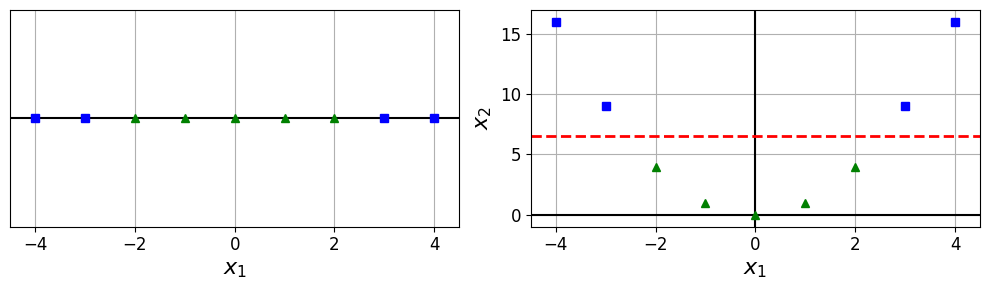

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


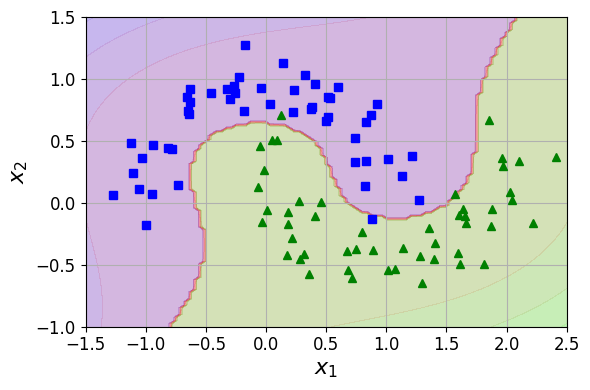

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC

# === Visualisasi Konsep Dimensi Tinggi ===
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

# Data 1D
plt.subplot(121)
plt.axhline(y=0, color='k'); plt.grid(True)
plt.plot(X1D[y==0], np.zeros_like(X1D[y==0]), "bs")
plt.plot(X1D[y==1], np.zeros_like(X1D[y==1]), "g^")
plt.xlabel(r"$x_1$", fontsize=16); plt.axis([-4.5, 4.5, -0.2, 0.2])
plt.gca().get_yaxis().set_ticks([])

# Data 2D (setelah transformasi x2 = x1^2)
plt.subplot(122)
plt.axhline(0, color='k'); plt.axvline(0, color='k'); plt.grid(True)
plt.plot(X2D[y==0][:, 0], X2D[y==0][:, 1], "bs")
plt.plot(X2D[y==1][:, 0], X2D[y==1][:, 1], "g^")
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=2)  # margin line
plt.xlabel(r"$x_1$", fontsize=16); plt.ylabel(r"$x_2$", fontsize=16)
plt.axis([-4.5, 4.5, -1, 17])
plt.tight_layout()
plt.show()

# === Dataset Make Moons (nonlinear) ===
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[y==0][:, 0], X[y==0][:, 1], "bs")
    plt.plot(X[y==1][:, 0], X[y==1][:, 1], "g^")
    plt.axis(axes); plt.grid(True)
    plt.xlabel(r"$x_1$", fontsize=16); plt.ylabel(r"$x_2$", fontsize=16)

# === Polynomial SVM ===
poly_svm = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42)),
])
poly_svm.fit(X, y)

# === Visualisasi Decision Boundary ===
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)
    y_scores = clf.decision_function(X_grid).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_scores, cmap=plt.cm.brg, alpha=0.1)

plt.figure(figsize=(6, 4))
plot_predictions(poly_svm, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.tight_layout()
plt.show()

## Polynomial Kernel

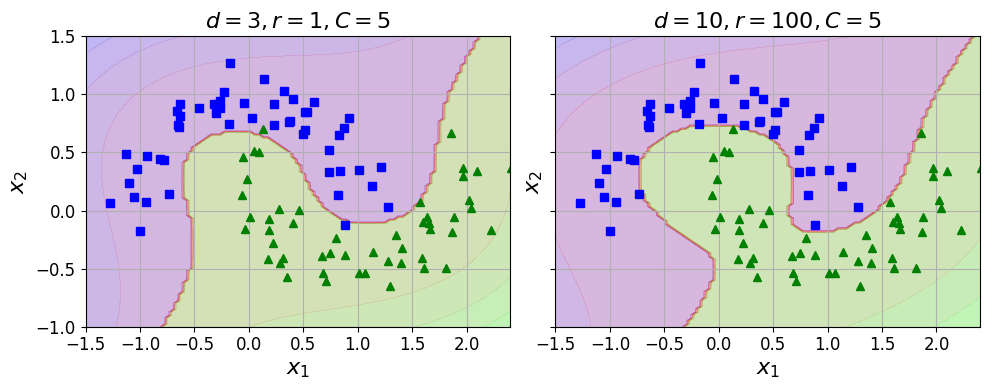

In [5]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# === Kernel SVM dengan Polynomial Kernel ===
poly_svm_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_svm_3.fit(X, y)

poly_svm_10 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])
poly_svm_10.fit(X, y)

# === Visualisasi Kedua Model ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_svm_3, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=16)

plt.sca(axes[1])
plot_predictions(poly_svm_10, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=16)

plt.tight_layout()
plt.show()

## Similarity Features

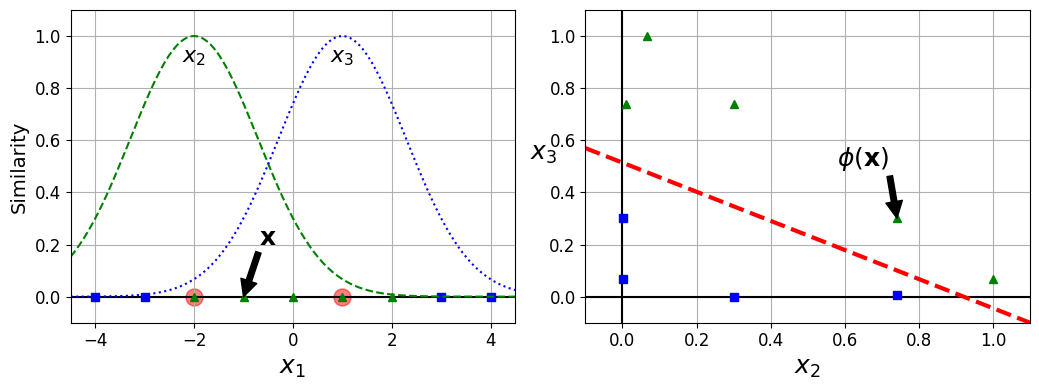

Phi(-1.0, -2) = 0.7408
Phi(-1.0, 1) = 0.3012


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# === Definisi RBF (Radial Basis Function) ===
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

# === Transformasi ke fitur kernel ===
x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]

# === Visualisasi Kemiripan & Proyeksi Kernel ===
plt.figure(figsize=(10.5, 4))

# Plot Kemiripan terhadap landmark
plt.subplot(121)
plt.axhline(0, color='k'); plt.grid(True)
plt.scatter([-2, 1], [0, 0], s=150, c="red", alpha=0.5)
plt.plot(X1D[yk==0], np.zeros_like(X1D[yk==0]), "bs")
plt.plot(X1D[yk==1], np.zeros_like(X1D[yk==1]), "g^")
plt.plot(x1s, x2s, "g--", label="similarity to -2")
plt.plot(x1s, x3s, "b:", label="similarity to +1")
plt.annotate(r'$\mathbf{x}$', xy=(X1D[3, 0], 0), xytext=(-0.5, 0.20),
             arrowprops=dict(facecolor='black'), fontsize=18, ha="center")
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=16)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=18)
plt.ylabel("Similarity", fontsize=14)
plt.axis([-4.5, 4.5, -0.1, 1.1])

# Plot proyeksi ke ruang fitur kernel (x2, x3)
plt.subplot(122)
plt.axhline(0, color='k'); plt.axvline(0, color='k'); plt.grid(True)
plt.plot(XK[yk==0][:, 0], XK[yk==0][:, 1], "bs")
plt.plot(XK[yk==1][:, 0], XK[yk==1][:, 1], "g^")
plt.annotate(r'$\phi(\mathbf{x})$', xy=(XK[3, 0], XK[3, 1]), xytext=(0.65, 0.50),
             arrowprops=dict(facecolor='black'), fontsize=18, ha="center")
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.xlabel(r"$x_2$", fontsize=18)
plt.ylabel(r"$x_3$", fontsize=18, rotation=0)
plt.axis([-0.1, 1.1, -0.1, 1.1])

plt.tight_layout()
plt.show()

# === Evaluasi contoh ===
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    sim = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print(f"Phi({x1_example}, {landmark}) = {sim[0]:.4f}")

## Gaussian RBF Kernel

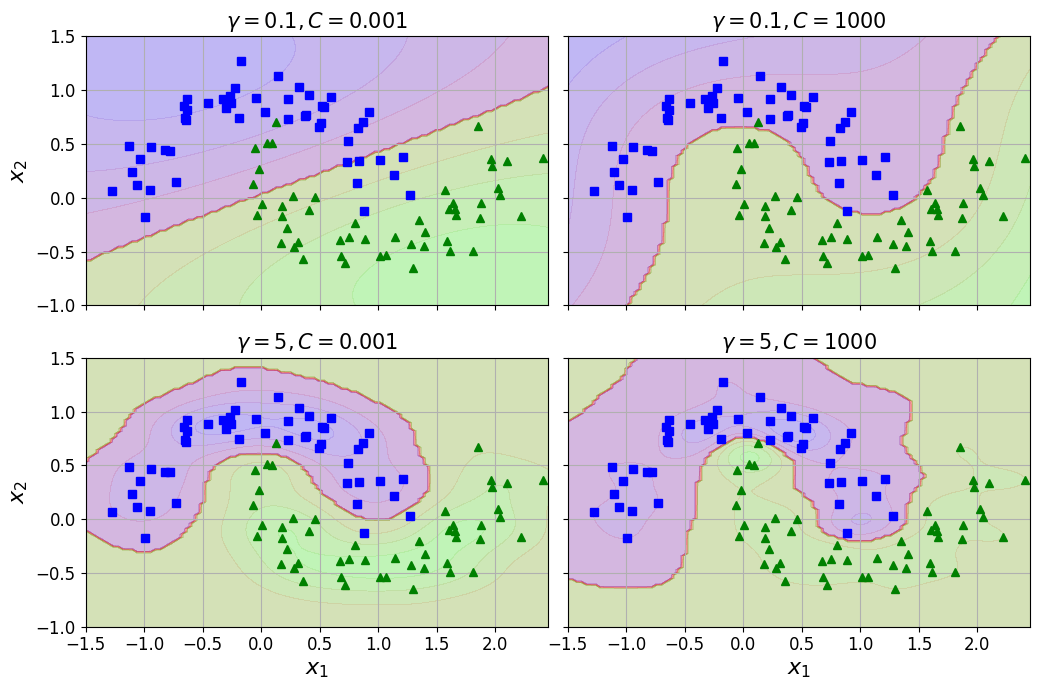

In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === Konfigurasi kombinasi hyperparameter RBF SVM ===
param_grid = [(0.1, 0.001), (0.1, 1000), (5, 0.001), (5, 1000)]
svm_clfs = []

# Latih model SVM RBF dengan tiap kombinasi gamma dan C
for gamma, C in param_grid:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    model.fit(X, y)
    svm_clfs.append(model)

# === Plot semua model pada satu grid 2x2 ===
fig, axes = plt.subplots(2, 2, figsize=(10.5, 7), sharex=True, sharey=True)

for idx, clf in enumerate(svm_clfs):
    plt.sca(axes[idx // 2, idx % 2])
    plot_predictions(clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = param_grid[idx]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=15)
    if idx in (0, 1): plt.xlabel("")
    if idx in (1, 3): plt.ylabel("")

plt.tight_layout()
plt.show()

## SVM Regression

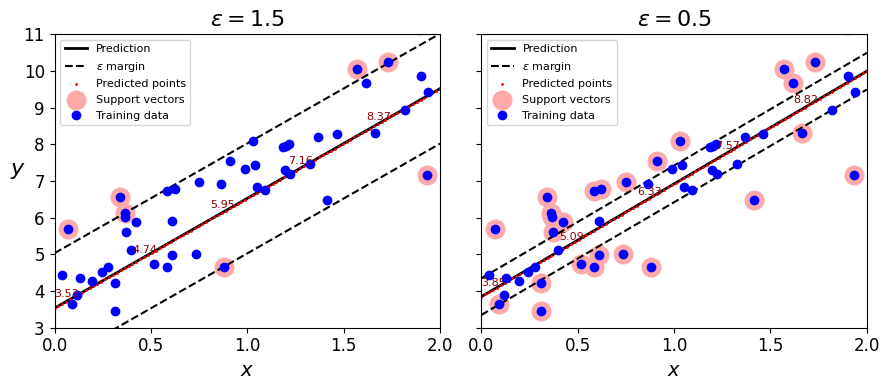

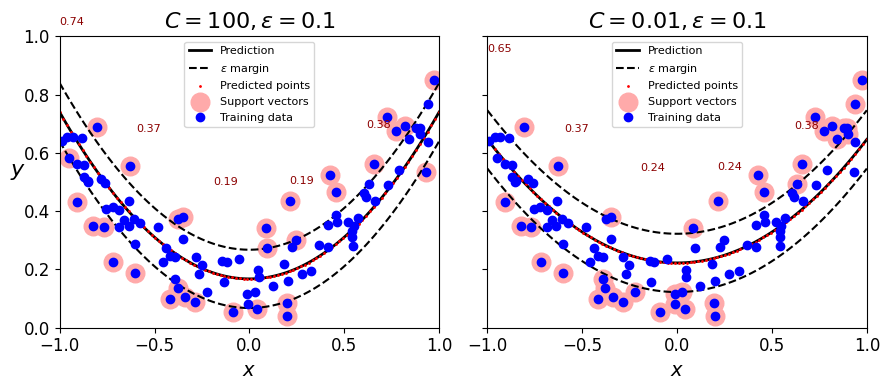

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR, SVR

# === Data Linear untuk LinearSVR ===
np.random.seed(42)
m = 50
X_lin = 2 * np.random.rand(m, 1)
y_lin = (4 + 3 * X_lin + np.random.randn(m, 1)).ravel()

# === Model LinearSVR dengan dua nilai epsilon ===
svr1 = LinearSVR(epsilon=1.5, random_state=42)
svr2 = LinearSVR(epsilon=0.5, random_state=42)
svr1.fit(X_lin, y_lin)
svr2.fit(X_lin, y_lin)

# === Fungsi untuk mencari support vectors
def find_support_vectors(svr, X, y):
    return np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon)

svr1.support_ = find_support_vectors(svr1, X_lin, y_lin)
svr2.support_ = find_support_vectors(svr2, X_lin, y_lin)

# === Fungsi plotting SVR (dengan nilai prediksi)
def plot_svm_regression(svr, X, y, axes, show_values=False):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(-1, 1)
    y_pred = svr.predict(x1s)

    plt.plot(x1s, y_pred, "k-", linewidth=2, label="Prediction")
    plt.plot(x1s, y_pred + svr.epsilon, "k--", label=r"$\epsilon$ margin")
    plt.plot(x1s, y_pred - svr.epsilon, "k--")
    plt.plot(x1s, y_pred, "r.", markersize=2, label="Predicted points")

    if hasattr(svr, "support_"):
        plt.scatter(X[svr.support_], y[svr.support_], s=180, facecolors='#FFAAAA', label="Support vectors")

    plt.plot(X, y, "bo", label="Training data")

    if show_values:
        for i in range(0, len(x1s), 20):
            plt.text(x1s[i], y_pred[i] + 0.3, f"{y_pred[i]:.2f}", fontsize=8, color="darkred")

    plt.xlabel(r"$x$", fontsize=14)
    plt.axis(axes)
    plt.legend(loc="best", fontsize=8)

# === Plot Linear SVR dengan nilai prediksi ditampilkan ===
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svr1, X_lin, y_lin, [0, 2, 3, 11], show_values=True)
plt.title(r"$\epsilon = {}$".format(svr1.epsilon), fontsize=16)
plt.ylabel(r"$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_svm_regression(svr2, X_lin, y_lin, [0, 2, 3, 11], show_values=True)
plt.title(r"$\epsilon = {}$".format(svr2.epsilon), fontsize=16)
plt.tight_layout()
plt.show()

# === Data Non-Linear untuk SVR Polinomial ===
np.random.seed(42)
m = 100
X_poly = 2 * np.random.rand(m, 1) - 1
y_poly = (0.2 + 0.1 * X_poly + 0.5 * X_poly**2 + np.random.randn(m, 1)/10).ravel()

# === Model SVR Polinomial dengan dua nilai C ===
svr_poly1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svr_poly2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svr_poly1.fit(X_poly, y_poly)
svr_poly2.fit(X_poly, y_poly)

# === Plot Polynomial SVR dengan nilai prediksi ditampilkan ===
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svr_poly1, X_poly, y_poly, [-1, 1, 0, 1], show_values=True)
plt.title(r"$C={}, \epsilon = {}$".format(svr_poly1.C, svr_poly1.epsilon), fontsize=16)
plt.ylabel(r"$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_svm_regression(svr_poly2, X_poly, y_poly, [-1, 1, 0, 1], show_values=True)
plt.title(r"$C={}, \epsilon = {}$".format(svr_poly2.C, svr_poly2.epsilon), fontsize=16)
plt.tight_layout()
plt.show()

## Under The Hood

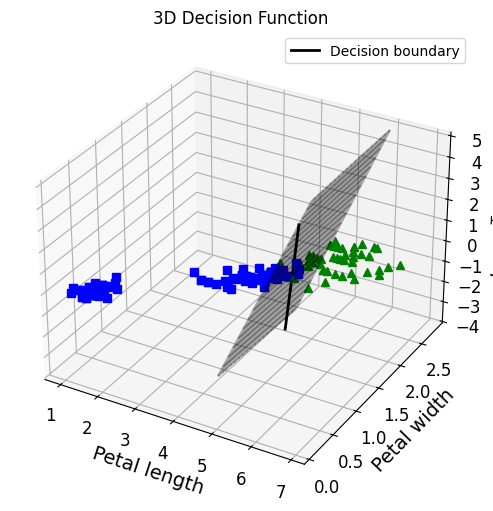

In [9]:
from sklearn import datasets
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Dataset Iris: Petal length & width ===
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]
y = (iris["target"] == 2).astype(np.float64)

# === Latih model SVM linear ===
svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)

# === Plot fungsi keputusan 3D ===
def plot_3D_decision_function(ax, w, b):
    x1s, x2s = np.linspace(4, 6, 20), np.linspace(0.8, 2.8, 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    df = (np.c_[x1.ravel(), x2.ravel()].dot(w) + b).reshape(x1.shape)
    margin = 1 / np.linalg.norm(w)

    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(x1s, -x1s * (w[0]/w[1]) - b / w[1], 0, "k-", linewidth=2, label="Decision boundary")
    ax.plot(X[y==1][:,0], X[y==1][:,1], 0, "g^")
    ax.plot(X[y==0][:,0], X[y==0][:,1], 0, "bs")
    ax.set_xlabel("Petal length")
    ax.set_ylabel("Petal width")
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$")
    ax.set_title("3D Decision Function")
    ax.legend()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax, svm_clf.coef_[0], svm_clf.intercept_[0])
plt.show()

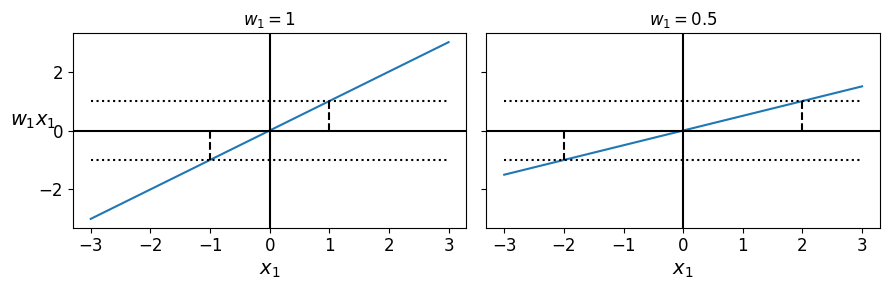

In [10]:
def plot_2D_decision_function(w, b=0, ylabel=True):
    x1 = np.linspace(-3, 3, 200)
    y = w * x1 + b
    margin = 1 / w

    plt.plot(x1, y)
    plt.plot(x1, np.ones_like(x1), "k:", label=r"$+1$")
    plt.plot(x1, -np.ones_like(x1), "k:", label=r"$-1$")
    plt.plot([margin, margin], [0, 1], "k--")
    plt.plot([-margin, -margin], [0, -1], "k--")
    plt.axhline(0, color="k")
    plt.axvline(0, color="k")
    plt.title(r"$w_1 = {}$".format(w))
    plt.xlabel(r"$x_1$")
    if ylabel: plt.ylabel(r"$w_1 x_1$", rotation=0)

fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
plt.sca(axes[0]); plot_2D_decision_function(1)
plt.sca(axes[1]); plot_2D_decision_function(0.5, ylabel=False)
plt.tight_layout()
plt.show()

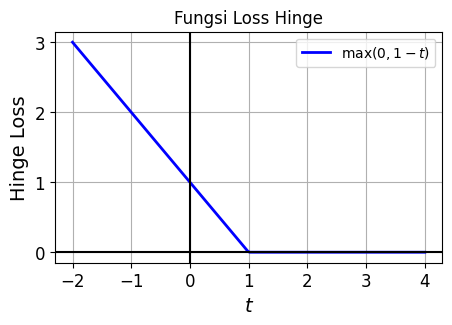

In [11]:
t = np.linspace(-2, 4, 200)
hinge = np.maximum(0, 1 - t)

plt.figure(figsize=(5, 3))
plt.plot(t, hinge, "b-", label=r"$\max(0, 1 - t)$", linewidth=2)
plt.axhline(0, color="k"); plt.axvline(0, color="k")
plt.grid(True)
plt.xlabel(r"$t$")
plt.ylabel("Hinge Loss")
plt.title("Fungsi Loss Hinge")
plt.legend()
plt.show()

# **Proses SVM Regression**

## 1. Persiapan Data Linear (LinearSVR)
Data dibuat berdasarkan fungsi linear: y = 4 + 3x + noise.
Dua model LinearSVR dilatih dengan nilai epsilon (ε) yang berbeda:

* ε = 1.5: margin lebih lebar.

* ε = 0.5: margin lebih sempit.

## 2. Pelatihan Model LinearSVR
Model LinearSVR dilatih untuk membentuk garis regresi linear.
Titik-titik yang berada di luar margin ±ε disebut support vectors.

Karena LinearSVR tidak menyediakan atribut support vectors secara langsung, pencarian dilakukan secara manual.

## 3. Visualisasi LinearSVR
Visualisasi mencakup:

* Garis prediksi utama.

* Garis margin atas dan bawah (±ε).

* Titik data pelatihan (ditandai biru).

* Titik prediksi model (ditandai merah).

* Nilai prediksi yang ditampilkan dalam bentuk teks pada beberapa titik tertentu.

## 4. Persiapan Data Non-Linear (SVR Polynomial)
Data dibuat berdasarkan fungsi kuadrat: y = 0.2 + 0.1x + 0.5x² + noise.

Dua model SVR dengan kernel polynomial (derajat = 2) digunakan:

* C = 100: model lebih kompleks dan lebih menyesuaikan data.

* C = 0.01: model lebih sederhana dan cenderung generalisasi.

## 5. Pelatihan dan Visualisasi SVR Polynomial
Model mempelajari pola non-linear pada data.
Visualisasi mencakup:

* Kurva prediksi utama.

* Margin ±ε.

* Titik support vectors.

* Nilai prediksi yang ditampilkan sebagai teks.

# **Kesimpulan**
* Epsilon (ε) memengaruhi lebar margin bebas penalti:

    * ε besar → toleransi lebih tinggi, menghasilkan lebih sedikit support vectors.

    * ε kecil → toleransi rendah, lebih sensitif terhadap noise.

* Parameter C menentukan kompleksitas model:

    * C besar → model lebih kompleks dan berisiko overfitting.

    * C kecil → model lebih sederhana dan cenderung underfitting.

* Support Vectors adalah titik-titik yang berada di luar margin ε dan berkontribusi langsung dalam membentuk model.

* Visualisasi nilai prediksi membantu dalam mengevaluasi performa dan akurasi estimasi model terhadap data.